# Kobe Bryant Data using CatBoost and LIME

## Description
In this notebook, we will give you a walktrough the [Kobe Bryant's data](https://www.kaggle.com/c/kobe-bryant-shot-selection/data). We have seen few notebooks and scritps that make use of LIME, but so far, I haven't seen one with [CatBoost](https://catboost.ai/). 


This notebook will contain the following structure:

1. Data Exploration
2. Feature engineering and selection
3. Model interpretacion
4. Conclusion

## References:

1. Most of this notebook is inspired by [ WillKoehrsen'project](https://github.com/WillKoehrsen/machine-learning-project-walkthrough)
2. [LIME](https://github.com/marcotcr/lime)
3. [Kobe Bryant's kaggle competetion](https://www.kaggle.com/c/kobe-bryant-shot-selection/data)
4. [sklearn's confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

## Developers:

1. Jose Nandez, <jose.nandez.ds@gmail.com>
2. Erika Munoz, <erika.munoz.datascientist@gmail.com>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

import catboost

import itertools

import lime
import lime.lime_tabular

from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns',None)
plt.style.use('fivethirtyeight')
%matplotlib inline

## Data Cleaning 

The first thing we will do is to clean up the data a bit. Note that this data is fairly clean, so no much cleaning is necessary.

### Loading the data

In [6]:
kobeDF = pd.read_csv("kobe_data/data.csv")

In [7]:
#display the first 5th rows
kobeDF.head()

action_type combined_shot_type  game_event_id   game_id      lat  \
0          Jump Shot          Jump Shot             10  20000012  33.9723   
1          Jump Shot          Jump Shot             12  20000012  34.0443   
2          Jump Shot          Jump Shot             35  20000012  33.9093   
3          Jump Shot          Jump Shot             43  20000012  33.8693   
4  Driving Dunk Shot               Dunk            155  20000012  34.0443   

   loc_x  loc_y       lon  minutes_remaining  period  playoffs   season  \
0    167     72 -118.1028                 10       1         0  2000-01   
1   -157      0 -118.4268                 10       1         0  2000-01   
2   -101    135 -118.3708                  7       1         0  2000-01   
3    138    175 -118.1318                  6       1         0  2000-01   
4      0      0 -118.2698                  6       2         0  2000-01   

   seconds_remaining  shot_distance  shot_made_flag       shot_type  \
0                 27             18             NaN  2PT Field Goal   
1                 22             15             0.0  2PT Field Goal   
2                 45             16             1.0  2PT Field Goal   
3                 52             22             0.0  2PT Field Goal   
4                 19              0             1.0  2PT Field Goal   

          shot_zone_area  shot_zone_basic  shot_zone_range     team_id  \
0          Right Side(R)        Mid-Range        16-24 ft.  1610612747   
1           Left Side(L)        Mid-Range         8-16 ft.  1610612747   
2   Left Side Center(LC)        Mid-Range        16-24 ft.  1610612747   
3  Right Side Center(RC)        Mid-Range        16-24 ft.  1610612747   
4              Center(C)  Restricted Area  Less Than 8 ft.  1610612747   

            team_name   game_date    matchup opponent  shot_id  
0  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        1  
1  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        2  
2  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        3  
3  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        4  
4  Los Angeles Lakers  2000-10-31  LAL @ POR      POR        5

You can easily see that there are lots of caterogical variables such as `action_type` and `combined_shot_type`. There are also continuos variables such as `lat` and `lon` which correspond to the Latitude and Longitude where the play ocurred.

### Getting a more detail explanation

In [8]:
#more detail explanation
kobeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

As mentioned in the competition, they removed few `shot_made_flag` corresponding to the test set. The rest of the variables seem not to have any missing values. Therefore, it is not necessary to fill any missing values with artificial methods.

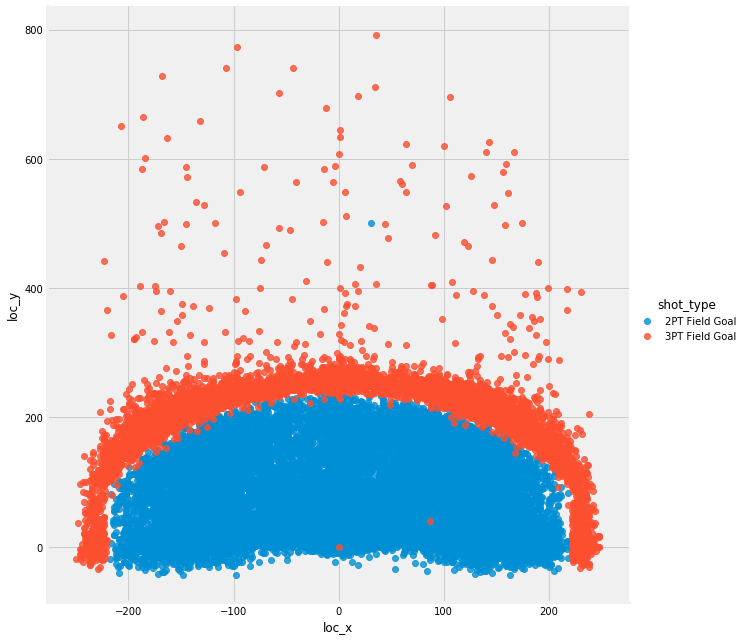

In [10]:
sns.lmplot("loc_x","loc_y",hue="shot_type",data=kobeDF,fit_reg=False,height=9);

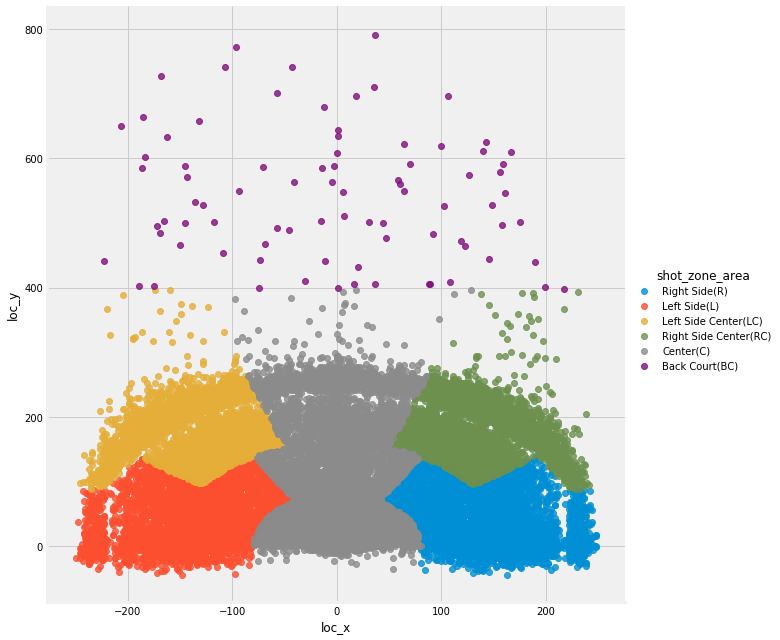

In [11]:
sns.lmplot("loc_x","loc_y",hue="shot_zone_area",data=kobeDF,fit_reg=False,height=9);

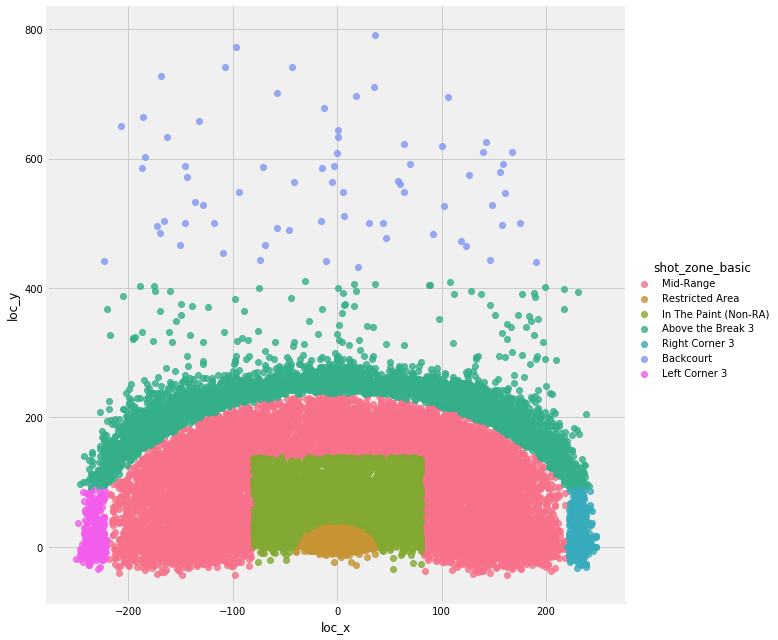

In [12]:
sns.lmplot("loc_x","loc_y",hue="shot_zone_basic",data=kobeDF,fit_reg=False,height=9);

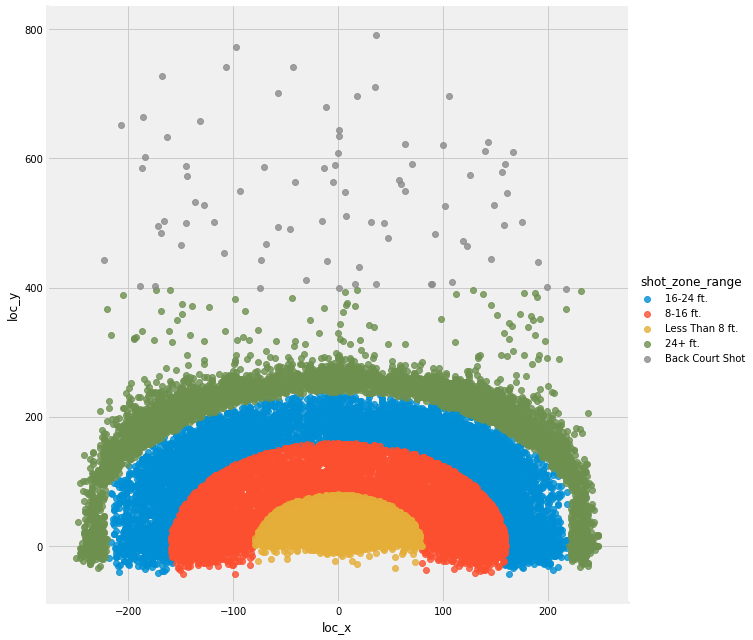

In [13]:
sns.lmplot("loc_x","loc_y",hue="shot_zone_range",data=kobeDF,fit_reg=False,height=9);

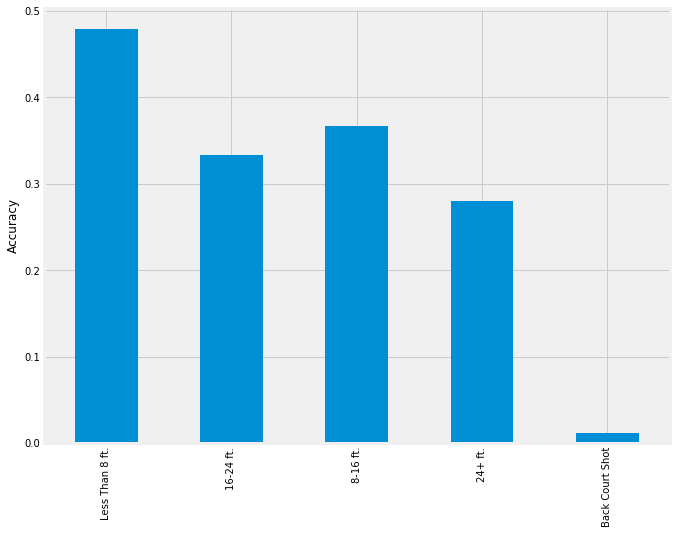

In [18]:
(kobeDF[kobeDF['shot_made_flag'] == 1].shot_zone_range.value_counts()/kobeDF.shot_zone_range.value_counts()).plot(kind='bar',figsize=(10,8))
plt.ylabel("Accuracy");

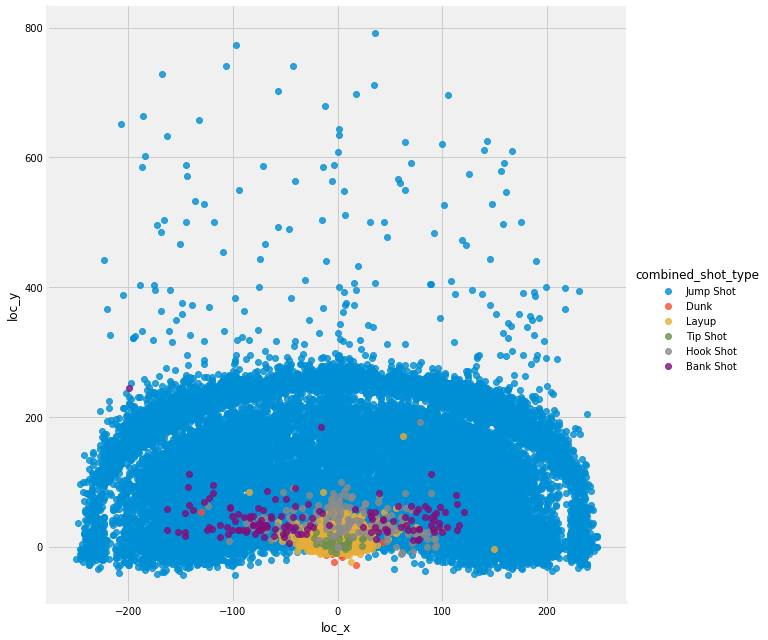

In [19]:
sns.lmplot("loc_x","loc_y",hue="combined_shot_type",data=kobeDF,fit_reg=False,height=9);

### Features selection: 1rs iteration

We can check the unique values in each column so we have some idea about which features we can use

In [20]:
print("Number of records in Kobe's dataset = ",kobeDF.shape[0])
kobeDF.nunique()

Number of records in Kobe's dataset =  30697


action_type              57
combined_shot_type        6
game_event_id           620
game_id                1559
lat                     457
loc_x                   489
loc_y                   457
lon                     489
minutes_remaining        12
period                    7
playoffs                  2
season                   20
seconds_remaining        60
shot_distance            74
shot_made_flag            2
shot_type                 2
shot_zone_area            6
shot_zone_basic           7
shot_zone_range           5
team_id                   1
team_name                 1
game_date              1559
matchup                  74
opponent                 33
shot_id               30697
dtype: int64


* action_type: categorical variable, this will be used since it specify what type of shot was taken: Used
* combined_shot_type: categorical vaiable, final action that lead to the shot, similar to the previous feature, although this is a more summarized action type: Used
* game_event_id: int, we will not use this feature since this is an id, does not have a meaning in the model: Not Used
* game_id: int, we will not use this feature since this is an id, does not have a meaning in the model: Not Used
* lat: numeric, this could be important, and it will be used in the first iteration: Used
* loc_x: numeric, important feature which can be combined with the `loc_y` to location the probability of the shot made or miss: Used
* loc_y: numeric, important feature which can be combined with the `loc_x` to location the probability of the shot made or miss: Used
* lon: numeric, combined with `lat` to see if this matter in the first iteration: Used
* minutes_remaining: numeric, can be combined to second_remaining to get a single feature: Feature Eng
* period: int, categorical variable which will represent in which period the shot was taken: Used
* playoffs: int, is this a playoffs shot?: Used
* season: string, categorical variable: Used
* seconds_remaining: int, can be combined with minutes remaining to get a single feature: Feature Eng
* shot_distance: int, how far Kobe was from the basket?: Used
* shot_made_flag: int, the target of our model: Not Used
* shot_type: string, categorical variable which described a 2pt or 3pt shot: Used
* shot_zone_area: string, categorical variable which gives the area from where the shot was taken: Used
* shot_zone_basic: string, categorical variable which described a more detailed area of the court: Used
* shot_zone_range: string, categorical variable which describes the range of the shot: Used
* team_id: int, single value in data set: Not Used
* team_name: string, single value in data set: Not Used
* game_date: date, this can be converted to a single variable, for example months: Feature Eng
* matchup: string, the matchup, can be engineered to get `is_home?`: Feature Eng
* opponent: string, categorical variable for the opponent: Used
* shot_id: int, internal index: Not Used

### Feature engineering

We will start by engineering the features we identified above after checking the values of check column

In [21]:
#combining the minutes and seconds remaining
kobeDF['game_clock_s'] = kobeDF.minutes_remaining*60 + kobeDF.seconds_remaining
#extract only the month, and this will be a categorical variable for the first iteration
kobeDF['month'] = pd.to_datetime(kobeDF.game_date).dt.month
#get is_home
kobeDF['is_home'] = ~kobeDF.matchup.str.contains('@')

In [22]:
pre_variables = ['action_type', 'combined_shot_type', 'lat', 'loc_x', 'loc_y', 
                 'lon', 'period', 'playoffs', 'season', 'shot_distance', 'shot_type', 
                 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'opponent', 
                 'game_clock_s', 'month', 'is_home']
cat_variables = ['action_type', 'combined_shot_type', 'season', 'shot_type','shot_zone_area', 
                 'shot_zone_basic', 'shot_zone_range', 'opponent','month','period']

Converting the `string` into `int` so it can be understood by CatBoost

In [23]:
for col in cat_variables:
    le = LabelEncoder()
    le.fit(kobeDF[col].values)
    kobeDF[col] = le.transform(kobeDF[col].values)

In [24]:
kobeDF[pre_variables].head()

action_type  combined_shot_type      lat  loc_x  loc_y       lon  period  \
0           26                   3  33.9723    167     72 -118.1028       0   
1           26                   3  34.0443   -157      0 -118.4268       0   
2           26                   3  33.9093   -101    135 -118.3708       0   
3           26                   3  33.8693    138    175 -118.1318       0   
4            5                   1  34.0443      0      0 -118.2698       1   

   playoffs  season  shot_distance  shot_type  shot_zone_area  \
0         0       4             18          0               5   
1         0       4             15          0               3   
2         0       4             16          0               2   
3         0       4             22          0               4   
4         0       4              0          0               1   

   shot_zone_basic  shot_zone_range  opponent  game_clock_s  month  is_home  
0                4                0        25           627      6    False  
1                4                2        25           622      6    False  
2                4                0        25           465      6    False  
3                4                0        25           412      6    False  
4                5                4        25           379      6    False

## First model using CatBoost

In [25]:
X_train = kobeDF[~kobeDF.shot_made_flag.isnull()]
X_test  = kobeDF[kobeDF.shot_made_flag.isnull()]

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train[pre_variables], X_train['shot_made_flag'], test_size = 0.2, random_state = 42)

In [27]:
list_cat_feat = []
for col in cat_variables:
    list_cat_feat.append(pre_variables.index(col))

train_pool = catboost.Pool(X_train, y_train, cat_features=list_cat_feat)
val_pool   = catboost.Pool(X_val, y_val, cat_features=list_cat_feat)

model = catboost.CatBoostClassifier(iterations=200, 
                            loss_function='MultiClass',
                            od_type='Iter',
                            od_wait=10,
                            boosting_type='Plain',
                            learning_rate=0.1,
                            depth=9,
                            bagging_temperature=0.,
                            border_count=250,
                            rsm=1,
                            task_type='CPU')

In [28]:
%%time
model.fit(train_pool,eval_set=val_pool,use_best_model=True)

0:	learn: -0.6799727	test: -0.6799750	best: -0.6799750 (0)	total: 103ms	remaining: 20.5s
1:	learn: -0.6690588	test: -0.6690482	best: -0.6690482 (1)	total: 162ms	remaining: 16s
2:	learn: -0.6595784	test: -0.6596550	best: -0.6596550 (2)	total: 278ms	remaining: 18.3s
3:	learn: -0.6514953	test: -0.6516138	best: -0.6516138 (3)	total: 421ms	remaining: 20.6s
4:	learn: -0.6444450	test: -0.6448270	best: -0.6448270 (4)	total: 542ms	remaining: 21.1s
5:	learn: -0.6389372	test: -0.6393346	best: -0.6393346 (5)	total: 672ms	remaining: 21.7s
6:	learn: -0.6345035	test: -0.6346911	best: -0.6346911 (6)	total: 795ms	remaining: 21.9s
7:	learn: -0.6308209	test: -0.6310980	best: -0.6310980 (7)	total: 849ms	remaining: 20.4s
8:	learn: -0.6274228	test: -0.6278652	best: -0.6278652 (8)	total: 1s	remaining: 21.3s
9:	learn: -0.6246855	test: -0.6250559	best: -0.6250559 (9)	total: 1.14s	remaining: 21.7s
10:	learn: -0.6225416	test: -0.6227494	best: -0.6227494 (10)	total: 1.19s	remaining: 20.4s
11:	learn: -0.6204923	te

In [29]:
feature_results = pd.DataFrame({'feature':X_train.columns,
                                'importance':model.feature_importances_
                               })
feature_results = feature_results.sort_values('importance',ascending=False).reset_index(drop=True)

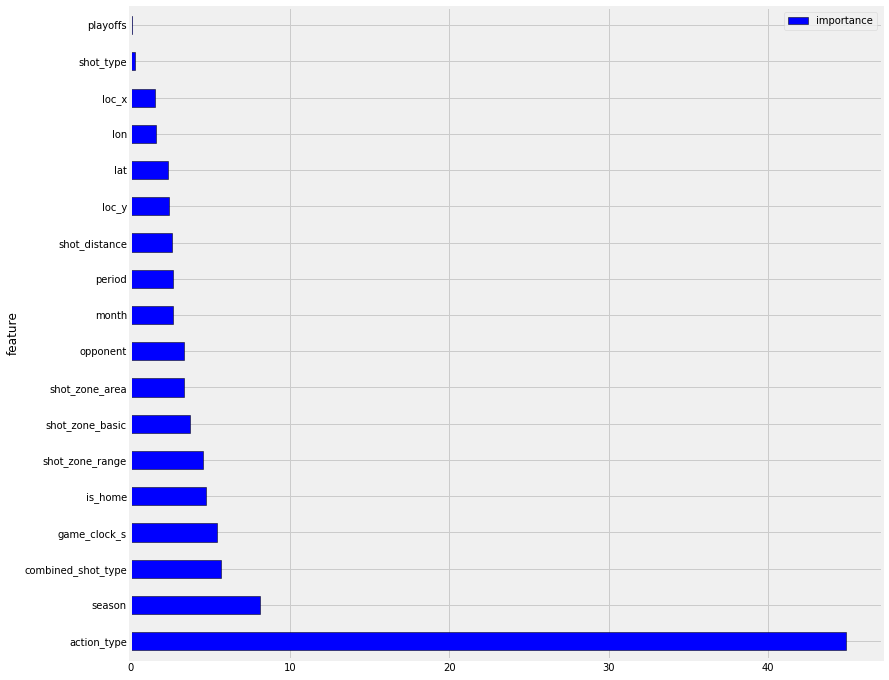

In [30]:
figsize(12,12)

feature_results.plot(x = 'feature', y='importance',edgecolor = 'k',kind='barh',color='blue')

### Feature selection: 2nd iteration
As seen by the previous plot, `shot_type` does not seem to contribute to the model at all, same thing for `playoffs` and `lon`. therefore, we will remove the following features: `shot_type`, `playoffs`, `lat` and `lon`. Note that we remove also `lat` since it is a coordinate system with `lon`, there is no point to keep it. 

In [31]:
pre_variables = ['action_type', 'combined_shot_type', 'loc_x', 'loc_y', 
                 'period', 'season', 'shot_distance', 'shot_zone_area', 
                 'shot_zone_basic', 'shot_zone_range', 'opponent', 
                 'game_clock_s', 'month', 'is_home']
cat_variables = ['action_type', 'combined_shot_type', 'season', 'shot_zone_area', 
                 'shot_zone_basic', 'shot_zone_range', 'opponent','month','period']

In [32]:
X_train = kobeDF[~kobeDF.shot_made_flag.isnull()]
X_train, X_val, y_train, y_val = train_test_split(X_train[pre_variables], X_train['shot_made_flag'], test_size = 0.2, random_state = 42)

In [33]:
X_train.head()

action_type  combined_shot_type  loc_x  loc_y  period  season  \
6560            33                   1      0      0       3       8   
1245            26                   3      1     91       2       4   
2517            26                   3   -187     17       2       5   
27712           26                   3    189     15       2       7   
23502           26                   3     27    119       2       1   

       shot_distance  shot_zone_area  shot_zone_basic  shot_zone_range  \
6560               0               1                5                4   
1245               9               1                2                2   
2517              18               3                4                0   
27712             18               5                4                0   
23502             12               1                2                2   

       opponent  game_clock_s  month  is_home  
6560         24           684      8     True  
1245          9           481      2     True  
2517         25           665      1    False  
27712         8           343      5    False  
23502         5             2      8     True

## 2nd Model using CatBoost

In [34]:
list_cat_feat = []
for col in cat_variables:
    list_cat_feat.append(pre_variables.index(col))

train_pool = catboost.Pool(X_train, y_train, cat_features=list_cat_feat)
val_pool   = catboost.Pool(X_val, y_val, cat_features=list_cat_feat)

model = catboost.CatBoostClassifier(iterations=200, 
                            loss_function='MultiClass',
                            od_type='Iter',
                            od_wait=10,
                            boosting_type='Plain',
                            learning_rate=0.1,
                            depth=9,
                            bagging_temperature=0.,
                            border_count=250,
                            rsm=1,
                            task_type='CPU')

In [35]:
%%time
model.fit(train_pool,eval_set=val_pool,use_best_model=True)

0:	learn: -0.6793259	test: -0.6794445	best: -0.6794445 (0)	total: 149ms	remaining: 29.6s
1:	learn: -0.6681381	test: -0.6685168	best: -0.6685168 (1)	total: 285ms	remaining: 28.3s
2:	learn: -0.6586372	test: -0.6589634	best: -0.6589634 (2)	total: 426ms	remaining: 28s
3:	learn: -0.6506855	test: -0.6511717	best: -0.6511717 (3)	total: 573ms	remaining: 28.1s
4:	learn: -0.6444979	test: -0.6448776	best: -0.6448776 (4)	total: 659ms	remaining: 25.7s
5:	learn: -0.6390991	test: -0.6395544	best: -0.6395544 (5)	total: 801ms	remaining: 25.9s
6:	learn: -0.6347668	test: -0.6350287	best: -0.6350287 (6)	total: 866ms	remaining: 23.9s
7:	learn: -0.6305202	test: -0.6307620	best: -0.6307620 (7)	total: 1.02s	remaining: 24.5s
8:	learn: -0.6271505	test: -0.6273560	best: -0.6273560 (8)	total: 1.18s	remaining: 25s
9:	learn: -0.6246520	test: -0.6248061	best: -0.6248061 (9)	total: 1.27s	remaining: 24.2s
10:	learn: -0.6216534	test: -0.6220336	best: -0.6220336 (10)	total: 1.4s	remaining: 24.1s
11:	learn: -0.6190801	te

With respect to the `log_loss`, there seems not to much of improvement from the previous model since we only removed non-useful features, further feature engineering will be required to make the model better.

In [36]:
feature_results = pd.DataFrame({'feature':X_train.columns,
                                'importance':model.feature_importances_
                               })
feature_results = feature_results.sort_values('importance',ascending=False).reset_index(drop=True)

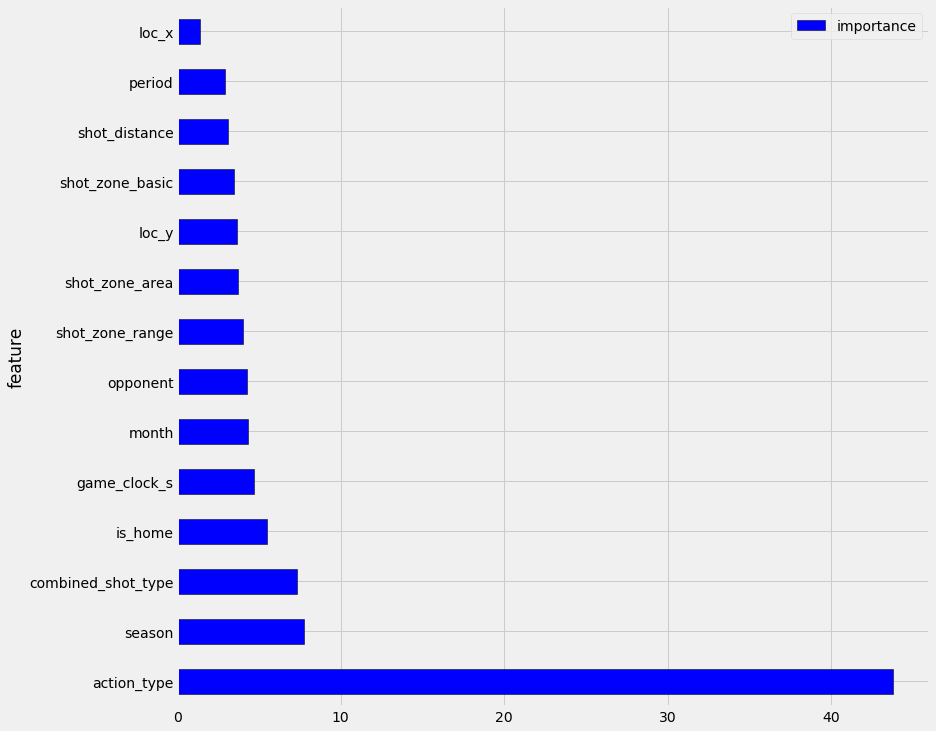

In [37]:
figsize(12,12)
plt.style.use('fivethirtyeight')

feature_results.plot(x = 'feature', y='importance',edgecolor = 'k',kind='barh',color='blue')

This graph looks a bit better than the previous one. Now, we will make plots that decide how good our model is and whether to trust it or not

## Confusion Matrix

In [38]:
#code taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Create the CatBoost dataset to be used for predictions

In [39]:
#create pred values
y_pred_prob = model.predict_proba(val_pool)
y_pred = model.predict(val_pool).ravel()

In [40]:
cnf_matrix = confusion_matrix(y_val,y_pred)

Normalized confusion matrix
[[0.87287842 0.12712158]
 [0.55082113 0.44917887]]


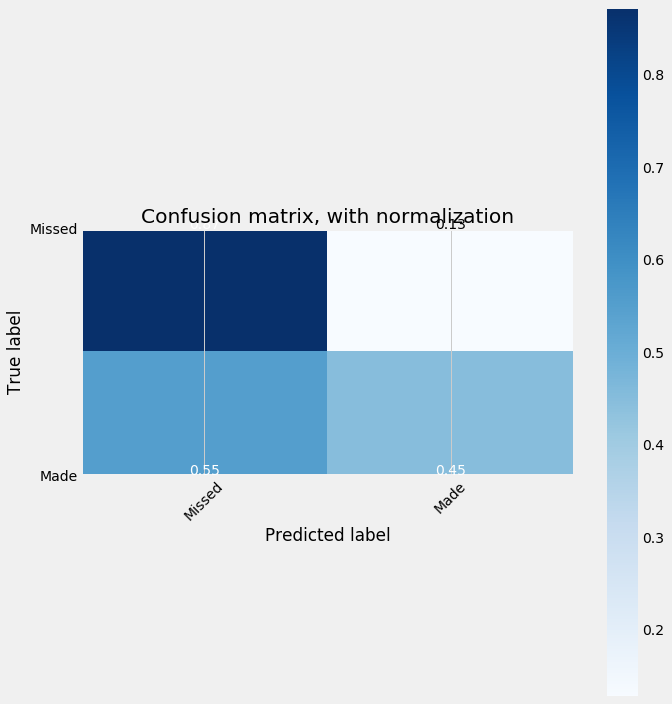

In [41]:
figsize(10,10)
plot_confusion_matrix(cnf_matrix, classes=['Missed','Made'],
                      normalize = True,
                      title='Confusion matrix, with normalization')

We can see that this model struggles to predict the `Made` shots, but it gets better probability for `Missed` shots. Let's take a look at invidual shots when the model gets it wrong and right.

## Locally Interpratable Model-agnostic Explanations
### Description
LIME is an algorithm that can explain the predictions of a classifier by approximating it locally with an interpretable model. For more information, please read the [LIME's paper](https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf). You can install LIME using `pip install lime` and the code can be found [here](https://github.com/marcotcr/lime). Note that in the tutorial there is no explanation for CatBoost, therefore, this notebook helps users to get started with CatBoost and LIME.

In [42]:
#first we need to create a wrapper
class catboost_predict_proba_wrapper:
    def __init__(self,model,column_names, list_cat_feat):
        self.model = model
        self.list_cat_feat = list_cat_feat
        self.column_names = column_names
    def predict_proba(self,this_array):
        shape_tuple = np.shape(this_array)
        if len(shape_tuple) == 1:
            this_array = this_array.reshape(1,-1)
        self.pandas_df = pd.DataFrame(data=this_array,columns=self.column_names)
        self.data_pool = catboost.Pool(self.pandas_df,cat_features=self.list_cat_feat)
        self.predictions = self.model.predict_proba(self.data_pool)
        return self.predictions

Create the explainer

In [43]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   class_names=['Missed','Made'],
                                                   feature_names=list(X_train.columns),
                                                   categorical_features=list_cat_feat,
                                                   categorical_names=cat_variables,
                                                   kernel_width=3
                                                  )

C:\Users\jluis\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [44]:
#create wrapper for the model using the defined class
class_names_dict = {0:'Missed',1:'Made'}
cat_wrapper = catboost_predict_proba_wrapper(model,pre_variables,list_cat_feat) 

In [45]:
wrong_id = y_val[y_val != y_pred].head(1).index[0]
print("The real outcome is ",class_names_dict[kobeDF.loc[wrong_id]['shot_made_flag']])
exp = explainer.explain_instance(X_val.loc[wrong_id].values.ravel(), cat_wrapper.predict_proba,num_features=10)
exp.show_in_notebook(show_all=True,show_predicted_value=True,show_table=True)

The real outcome is  Made


In [46]:
wrong_id = y_val[y_val != y_pred].head(2).tail(1).index[0]
print("The real outcome is ",class_names_dict[kobeDF.loc[wrong_id]['shot_made_flag']])
exp = explainer.explain_instance(X_val.loc[wrong_id].values.ravel(), cat_wrapper.predict_proba,num_features=10)
exp.show_in_notebook(show_all=True,show_predicted_value=True,show_table=True)

The real outcome is  Missed


`action_type` seems to be the one overfitting the data in order to predict a `Missed` shot.

In [47]:
right_id = y_val[y_val == y_pred].head(1).index[0]
print("The real outcome is ",class_names_dict[kobeDF.loc[right_id]['shot_made_flag']])
exp = explainer.explain_instance(X_val.loc[right_id].values.ravel(), cat_wrapper.predict_proba,num_features=10)
exp.show_in_notebook(show_all=True,show_predicted_value=True,show_table=True)

The real outcome is  Missed


Definitely `action_type` is a feature that really contributes to our model, either overfitting it or underfitting it. In order to get a more general model, one will need to further engineer

### Checking the accuracy and log loss

In [48]:
print("Best log loss = ",log_loss(y_val,y_pred_prob))
print("Accuracy = ",accuracy_score(y_pred=y_pred,y_true=y_val))

Best log loss =  0.601429960070735
Accuracy =  0.68715953307393


## Preparing for submission

The following piece of code is for creating your submission for kaggle in case you want to check your progress.

In [49]:
test_pool = catboost.Pool(X_test[pre_variables],cat_features=list_cat_feat)
y_test = model.predict_proba(test_pool)[:, 1]

In [51]:
pd.DataFrame({'shot_id':X_test.shot_id,'shot_made_flag':y_test}).to_csv("submission.csv",index=None)

This submission will give a final score of `0.60401`, which will give you a position in the `~320`.  

## Conclusion

In this notebook, we carried out the 

1. Data Exploration
2. Feature engineering and selection for the Kobe Bryant dataset
3. Use CatBoost as the main machine learning algorithm
4. Plot the Confusion Matrix to check how good are model is
5. Use LIME to interpret which feature is the most important and overfitting or underfitting our model

Our main conclusions are as follows:
1. Based on LIME, we can conclude that we need further feature engineering in order to get the `action_type` feature to better contribute in our model in a generalized way, since its contribution is about ~25% in the probability. 
2. Based on LIME and feature importance plot, we see that a hypertunning might help to create a flatter distribution of the feature importance in catboost
3. A recommendation would be to remove `action_type` from the pool of features and see how the model performance decreases or increases.

